# Exploratory Data Analysis

# Import Libraries and Custom Function

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 150)
pd.set_option('display.max_rows', 150)
import seaborn as sns


from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder

from sklearn.feature_selection import SelectKBest, f_classif

import warnings
warnings.filterwarnings('ignore')

In [2]:
# check dataset missing values
def check_null(df, ascending = False):
    # create series of null columns and null qty
    series = df.isnull().sum()

    # take only columns that has null values
    series = series[series > 0]

    # calculate percent
    percent = 100 * series / df.shape[0]

    # check dtype
    coldtype = df[series.index].dtypes

    # create dataframe
    result = pd.DataFrame({
        'QTY' : series, 'Percent' : percent, 'dtypes' : coldtype
    })

    if ascending != None:
        result.sort_values(by = 'QTY', ascending = ascending, inplace = True)

    return result

# Loading Data

In [3]:
train_df = pd.read_csv('./dataset/prepared_dataset/comb_train.csv', index_col = 'SK_ID_CURR')
test_df = pd.read_csv('./dataset/prepared_dataset/comb_test.csv', index_col = 'SK_ID_CURR')
train_df.head()

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_2,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,PREV_AMT_CREDIT,PREV_AMT_INSTALMENT,PREV_AMT_PAYMENT,AMT_CREDIT_SUM_BUREAU,AMT_CREDIT_SUM_DEBT_BUREAU,CNT_STATUS_BUREAU_BALANCE_0,CNT_STATUS_BUREAU_BALANCE_1,CNT_STATUS_BUREAU_BALANCE_2,CNT_STATUS_BUREAU_BALANCE_3,CNT_STATUS_BUREAU_BALANCE_4,CNT_STATUS_BUREAU_BALANCE_5,CNT_STATUS_BUREAU_BALANCE_C,CNT_STATUS_BUREAU_BALANCE_X
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,1,1,0,1,1,0,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.262949,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,179055.0,219625.695,219625.695,481988.565,245781.0,7.0,6.0,0.0,0.0,0.0,0.0,2.0,5.0
100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,1,1,0,1,1,0,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.622246,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1452573.0,1618864.650,1618864.650,810000.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,1,1,1,1,1,0,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,0.555912,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,20106.0,21288.465,21288.465,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833.0,-2437,1,1,0,1,0,0,2.0,2,2,WEDNESDAY,17,0,0,0,0,0,0,Business Entity Type 3,0.650442,2.0,0.0,2.0,0.0,-617.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1718644.5,1007153.415,1007153.415,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.028663,-19932,-3038,-4311.0,-3458,1,1,0,1,0,0,1.0,2,2,THURSDAY,11,0,0,0,0,1,1,Religion,0.322738,0.0,0.0,0.0,0.0,-1106.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,999832.5,835985.340,806127.975,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Problem Statements

In [4]:
previous_credit = train_df.loc[train_df.PREV_AMT_PAYMENT > 0, :]

previous_credit_health = previous_credit.PREV_AMT_PAYMENT - previous_credit.PREV_AMT_INSTALMENT
previous_credit_health = pd.DataFrame(previous_credit_health, columns = ['MARGIN'])
previous_credit_health['CAT'] = previous_credit_health['MARGIN'].apply(lambda x: 'Profit' if x >= 0 else 'Loss')

In [5]:
# see all number of losses applicants
unpaid_debt = previous_credit_health.loc[previous_credit_health.CAT == 'Loss']['MARGIN'].sum()

print(f"Total Unpaid Debt : Rp.{unpaid_debt :,.2f}")

Total Unpaid Debt : Rp.-7,359,654,383.86


<Axes: xlabel='CAT', ylabel='count'>

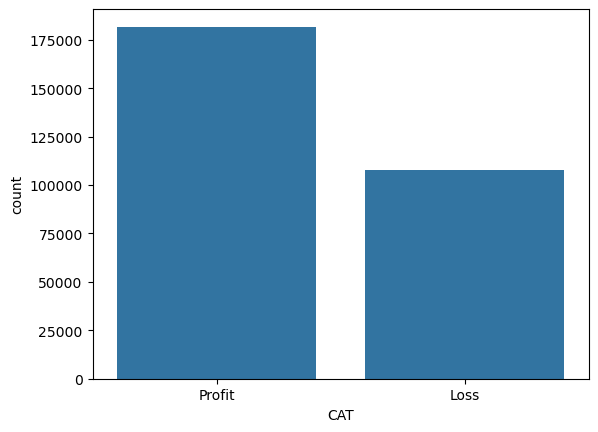

In [6]:
# see all number of losses applicants
sns.barplot(previous_credit_health['CAT'].value_counts())

## Column Datatype Definition

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 307511 entries, 100002 to 456255
Data columns (total 77 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   TARGET                       307511 non-null  int64  
 1   NAME_CONTRACT_TYPE           307511 non-null  object 
 2   CODE_GENDER                  307511 non-null  object 
 3   FLAG_OWN_CAR                 307511 non-null  object 
 4   FLAG_OWN_REALTY              307511 non-null  object 
 5   CNT_CHILDREN                 307511 non-null  int64  
 6   AMT_INCOME_TOTAL             307511 non-null  float64
 7   AMT_CREDIT                   307511 non-null  float64
 8   AMT_ANNUITY                  307511 non-null  float64
 9   AMT_GOODS_PRICE              307511 non-null  float64
 10  NAME_TYPE_SUITE              307511 non-null  object 
 11  NAME_INCOME_TYPE             307511 non-null  object 
 12  NAME_EDUCATION_TYPE          307511 non-null  object 
 13 

In [8]:
X = train_df.iloc[:,1:]
y = train_df.iloc[:,0]

In [9]:
num_cols = list()
cat_cols = list()

for col in X.columns:
    if X[col].dtype == 'O':
        cat_cols.append(col)
    else:
        num_cols.append(col)

len(num_cols), len(cat_cols)

(65, 11)

# Find Important Features

## Feature Importances Using Model

In [10]:
# encode data
oe = OrdinalEncoder()
oe.fit(X)

# transform encoded data
X_en = pd.DataFrame(oe.transform(X), columns=oe.feature_names_in_)
X_en.head()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_2,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,PREV_AMT_CREDIT,PREV_AMT_INSTALMENT,PREV_AMT_PAYMENT,AMT_CREDIT_SUM_BUREAU,AMT_CREDIT_SUM_DEBT_BUREAU,CNT_STATUS_BUREAU_BALANCE_0,CNT_STATUS_BUREAU_BALANCE_1,CNT_STATUS_BUREAU_BALANCE_2,CNT_STATUS_BUREAU_BALANCE_3,CNT_STATUS_BUREAU_BALANCE_4,CNT_STATUS_BUREAU_BALANCE_5,CNT_STATUS_BUREAU_BALANCE_C,CNT_STATUS_BUREAU_BALANCE_X
0,0.0,1.0,0.0,1.0,0.0,1754.0,1191.0,4589.0,190.0,7.0,7.0,4.0,3.0,1.0,63.0,15684.0,11935.0,12039.0,4047.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,6.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,28076.0,2.0,2.0,2.0,2.0,2638.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34097.0,110290.0,112376.0,31286.0,49224.0,7.0,6.0,0.0,0.0,0.0,0.0,2.0,5.0
1,0.0,0.0,0.0,0.0,0.0,2064.0,4338.0,6986.0,705.0,2.0,4.0,1.0,1.0,1.0,11.0,8382.0,11384.0,14501.0,5876.0,1.0,1.0,0.0,1.0,1.0,0.0,2.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,39.0,85082.0,1.0,0.0,1.0,0.0,2944.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,140610.0,253404.0,252081.0,44701.0,987.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1.0,1.0,1.0,0.0,338.0,228.0,663.0,31.0,7.0,7.0,4.0,3.0,1.0,47.0,6101.0,12347.0,11427.0,3636.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,72834.0,0.0,0.0,0.0,0.0,2957.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1213.0,2208.0,2381.0,0.0,987.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,1170.0,836.0,5681.0,146.0,7.0,7.0,4.0,0.0,1.0,34.0,6142.0,9533.0,5854.0,3730.0,1.0,1.0,0.0,1.0,0.0,0.0,2.0,1.0,1.0,6.0,17.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,90562.0,2.0,0.0,2.0,0.0,3155.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,149061.0,226484.0,226321.0,0.0,987.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,1.0,0.0,1019.0,1635.0,3961.0,353.0,7.0,7.0,4.0,3.0,1.0,74.0,5215.0,9534.0,11376.0,2709.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,4.0,11.0,0.0,0.0,0.0,0.0,1.0,1.0,37.0,36024.0,0.0,0.0,0.0,0.0,2666.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,120328.0,214154.0,212077.0,0.0,987.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
# fit Random Forest Model
clf = RandomForestClassifier()
clf.fit(X_en, y)

RandomForestClassifier()

Text(0.5, 1.0, 'feature importance score')

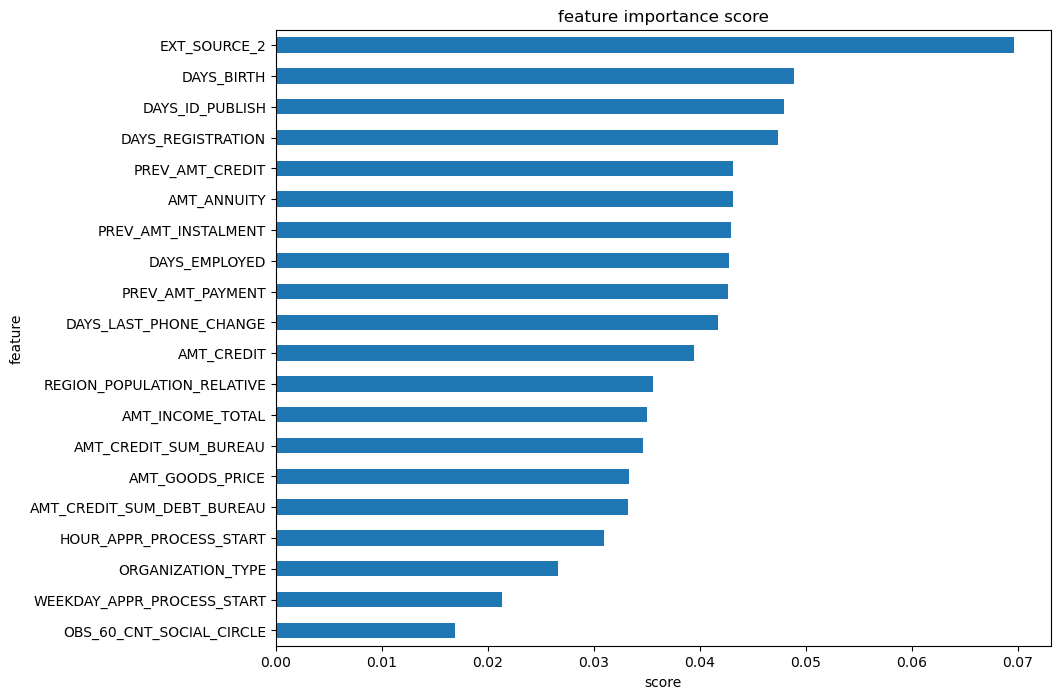

In [12]:
n_feature_interest = 20

feat_importances_by_model = pd.Series(clf.feature_importances_, index=X.columns)
ax = feat_importances_by_model.nlargest(n_feature_interest).plot(kind='barh', figsize=(10, 8))
ax.invert_yaxis()

plt.xlabel('score')
plt.ylabel('feature')
plt.title('feature importance score')

In [13]:
largest_feature_importances_by_model = set(feat_importances_by_model.nlargest(n_feature_interest).index.to_list())

## Feature Importances Univariate Analysis

In [14]:
selector = SelectKBest(f_classif, k=n_feature_interest)
selector.fit(X_en, y)
p, f = selector.pvalues_, selector.scores_

In [15]:
p_treshold = .05

result = pd.DataFrame(np.concatenate([p.reshape(-1,1),f.reshape(-1, 1)], axis=1), 
                      columns = ['p_val', 'f_score'], 
                      index=selector.feature_names_in_)

result_significant = result[result['p_val']<p_treshold].copy()

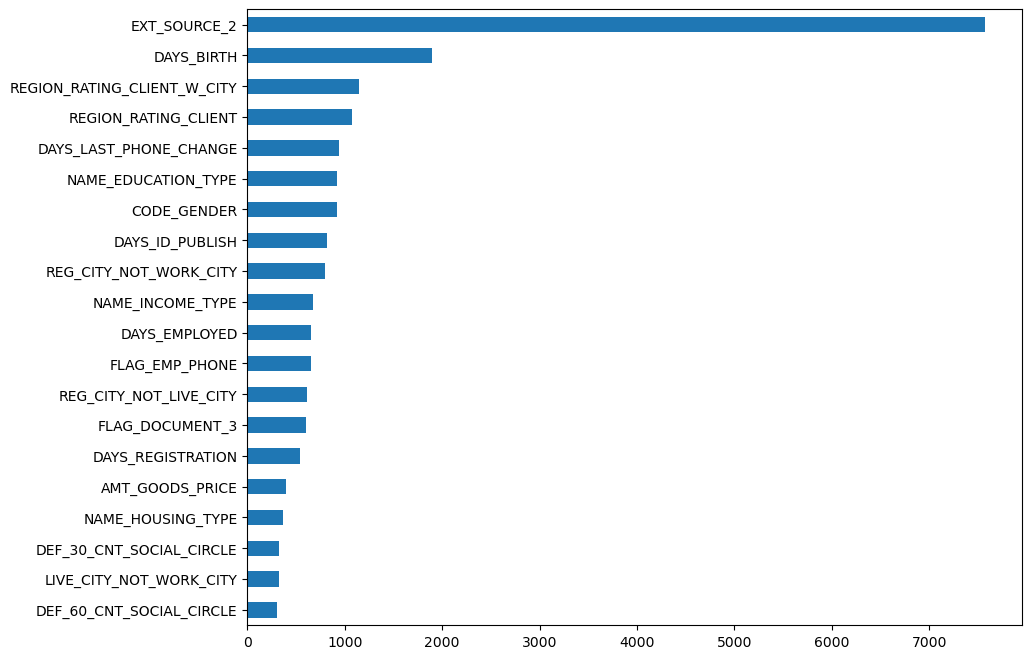

In [16]:
ax = result_significant['f_score'].nlargest(n_feature_interest).plot(kind='barh', figsize=(10, 8))
ax.invert_yaxis()

In [17]:
largest_feature_importances_by_univariate_analysis = set(result_significant['f_score'].nlargest(n_feature_interest).index.to_list())

## Combine Importance Features

In [18]:
selected_features = largest_feature_importances_by_model.union(largest_feature_importances_by_univariate_analysis)
selected_features = list(selected_features)
selected_features

['DAYS_REGISTRATION',
 'WEEKDAY_APPR_PROCESS_START',
 'AMT_ANNUITY',
 'REGION_POPULATION_RELATIVE',
 'FLAG_DOCUMENT_3',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'FLAG_EMP_PHONE',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'DAYS_ID_PUBLISH',
 'DAYS_EMPLOYED',
 'LIVE_CITY_NOT_WORK_CITY',
 'HOUR_APPR_PROCESS_START',
 'REG_CITY_NOT_WORK_CITY',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'REG_CITY_NOT_LIVE_CITY',
 'AMT_GOODS_PRICE',
 'NAME_HOUSING_TYPE',
 'AMT_INCOME_TOTAL',
 'NAME_INCOME_TYPE',
 'AMT_CREDIT_SUM_BUREAU',
 'REGION_RATING_CLIENT',
 'DAYS_BIRTH',
 'PREV_AMT_CREDIT',
 'AMT_CREDIT',
 'EXT_SOURCE_2',
 'AMT_CREDIT_SUM_DEBT_BUREAU',
 'ORGANIZATION_TYPE',
 'PREV_AMT_PAYMENT',
 'REGION_RATING_CLIENT_W_CITY',
 'CODE_GENDER',
 'NAME_EDUCATION_TYPE',
 'DAYS_LAST_PHONE_CHANGE',
 'PREV_AMT_INSTALMENT']

In [19]:
len(selected_features)

33

# Exploratory Data Analysis on Importance Features

## Preparations: Defining Dtypes

In [20]:
X_selected = train_df[selected_features]
X_selected.head()

,DAYS_REGISTRATION,WEEKDAY_APPR_PROCESS_START,AMT_ANNUITY,REGION_POPULATION_RELATIVE,FLAG_DOCUMENT_3,DEF_30_CNT_SOCIAL_CIRCLE,FLAG_EMP_PHONE,OBS_60_CNT_SOCIAL_CIRCLE,DAYS_ID_PUBLISH,DAYS_EMPLOYED,LIVE_CITY_NOT_WORK_CITY,HOUR_APPR_PROCESS_START,REG_CITY_NOT_WORK_CITY,DEF_60_CNT_SOCIAL_CIRCLE,REG_CITY_NOT_LIVE_CITY,AMT_GOODS_PRICE,NAME_HOUSING_TYPE,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,AMT_CREDIT_SUM_BUREAU,REGION_RATING_CLIENT,DAYS_BIRTH,PREV_AMT_CREDIT,AMT_CREDIT,EXT_SOURCE_2,AMT_CREDIT_SUM_DEBT_BUREAU,ORGANIZATION_TYPE,PREV_AMT_PAYMENT,REGION_RATING_CLIENT_W_CITY,CODE_GENDER,NAME_EDUCATION_TYPE,DAYS_LAST_PHONE_CHANGE,PREV_AMT_INSTALMENT
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100002,-3648.0,WEDNESDAY,24700.5,0.018801,1,2.0,1,2.0,-2120,-637,0,10,0,2.0,0,351000.0,House / apartment,202500.0,Working,481988.565,2,-9461,179055.0,406597.5,0.262949,245781.0,Business Entity Type 3,219625.695,2,M,Secondary / secondary special,-1134.0,219625.695
100003,-1186.0,MONDAY,35698.5,0.003541,1,0.0,1,1.0,-291,-1188,0,11,0,0.0,0,1129500.0,House / apartment,270000.0,State servant,810000.000,1,-16765,1452573.0,1293502.5,0.622246,0.0,School,1618864.650,1,F,Higher education,-828.0,1618864.650
100004,-4260.0,MONDAY,6750.0,0.010032,0,0.0,1,0.0,-2531,-225,0,9,0,0.0,0,135000.0,House / apartment,67500.0,Working,0.000,2,-19046,20106.0,135000.0,0.555912,0.0,Government,21288.465,2,M,Secondary / secondary special,-815.0,21288.465
100006,-9833.0,WEDNESDAY,29686.5,0.008019,1,0.0,1,2.0,-2437,-3039,0,17,0,0.0,0,297000.0,House / apartment,135000.0,Working,0.000,2,-19005,1718644.5,312682.5,0.650442,0.0,Business Entity Type 3,1007153.415,2,F,Secondary / secondary special,-617.0,1007153.415
100007,-4311.0,THURSDAY,21865.5,0.028663,0,0.0,1,0.0,-3458,-3038,1,11,1,0.0,0,513000.0,House / apartment,121500.0,Working,0.000,2,-19932,999832.5,513000.0,0.322738,0.0,Religion,806127.975,2,M,Secondary / secondary special,-1106.0,835985.340


In [21]:
cnum_cols = [
    'AMT_CREDIT_SUM_BUREAU',
    'DAYS_REGISTRATION',
    'DAYS_EMPLOYED',
    'DAYS_LAST_PHONE_CHANGE',
    'EXT_SOURCE_2',
    'PREV_AMT_PAYMENT',
    'REGION_POPULATION_RELATIVE',
    'AMT_ANNUITY',
    'DAYS_BIRTH',
    'AMT_GOODS_PRICE',
    'PREV_AMT_INSTALMENT',
    'AMT_CREDIT_SUM_DEBT_BUREAU',
    'DAYS_ID_PUBLISH',
    'PREV_AMT_CREDIT',
    'AMT_INCOME_TOTAL',
    'AMT_CREDIT',
    'HOUR_APPR_PROCESS_START',
    'DEF_60_CNT_SOCIAL_CIRCLE',
    'DEF_30_CNT_SOCIAL_CIRCLE',
    'LIVE_CITY_NOT_WORK_CITY',
    'OBS_30_CNT_SOCIAL_CIRCLE'
]

cat_cols = [
    'FLAG_EMP_PHONE',
    'FLAG_DOCUMENT_3',
    'REG_CITY_NOT_WORK_CITY',
    'REG_CITY_NOT_LIVE_CITY',
    'NAME_INCOME_TYPE',
    'WEEKDAY_APPR_PROCESS_START',
    'NAME_EDUCATION_TYPE',
    'NAME_HOUSING_TYPE',
    'ORGANIZATION_TYPE',
    'CODE_GENDER'
]

dnum_cols = [
    col for col in X_selected.columns if col not in cnum_cols+cat_cols
]

num_cols = cnum_cols + dnum_cols

len(cnum_cols), len(cat_cols), len(dnum_cols)

(21, 10, 3)

## Univariate Exploratory Data Analysis

### Continuous Numerical Features

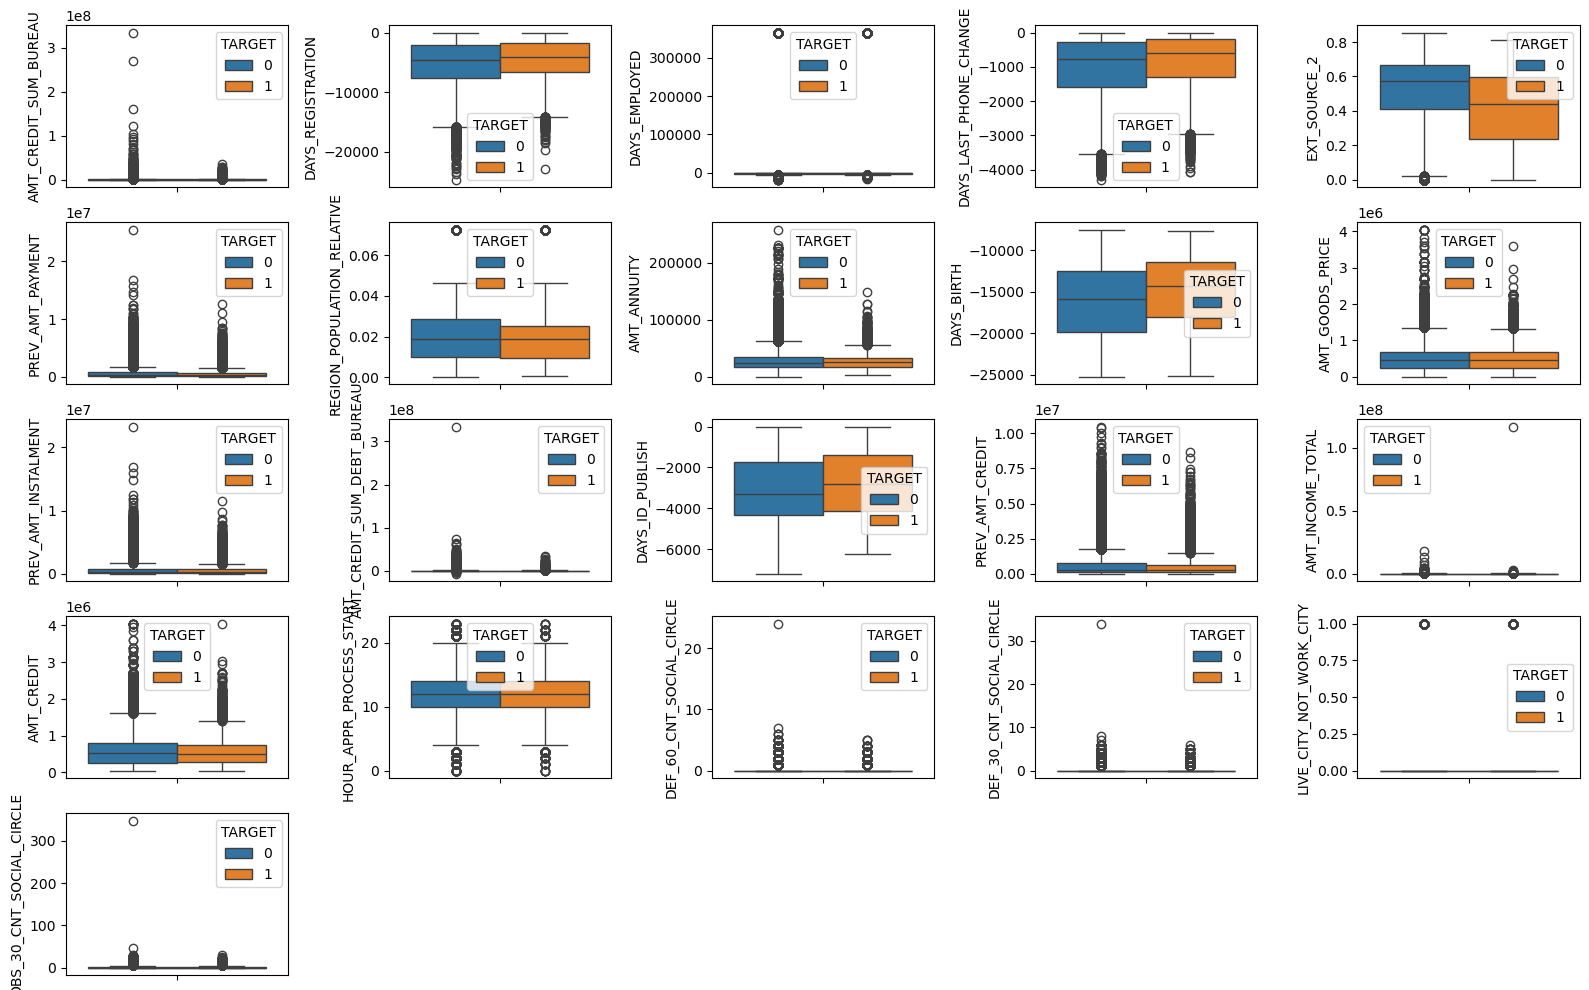

In [22]:
plt.figure(figsize = (16,10))
for i in range(len(cnum_cols)):
    plt.subplot(5, round(len(cnum_cols)/4), i+1)
    sns.boxplot(train_df, y = cnum_cols[i], hue='TARGET', orient = 'v')
    plt.tight_layout()

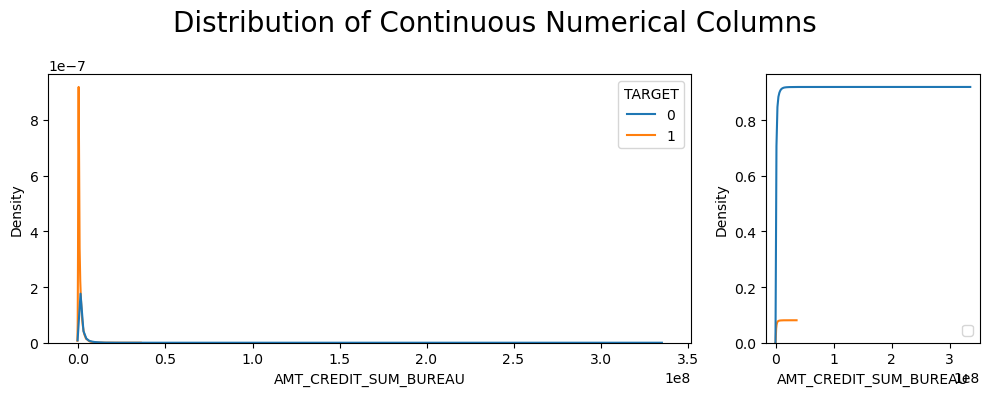

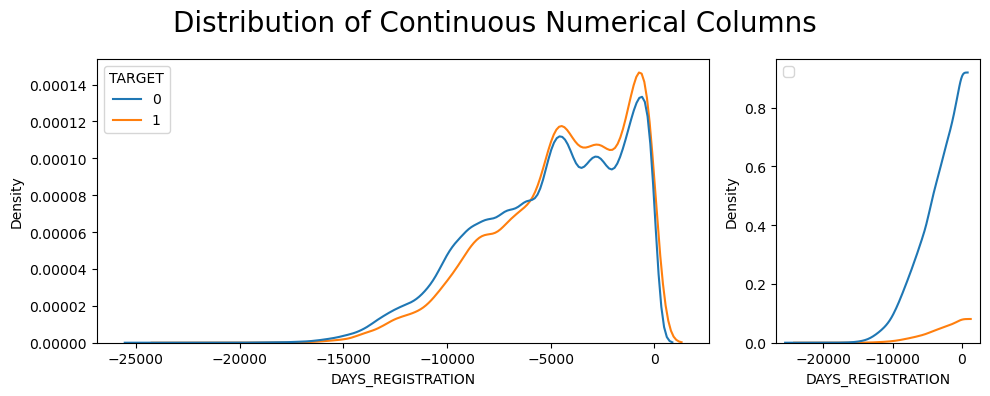

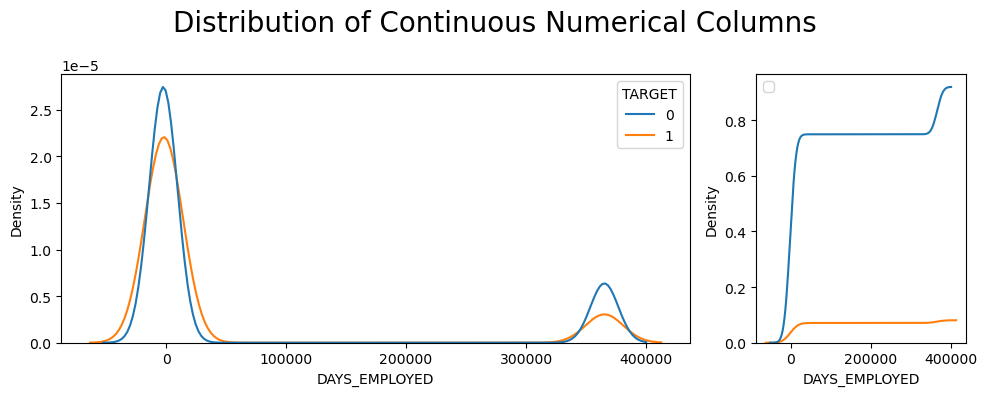

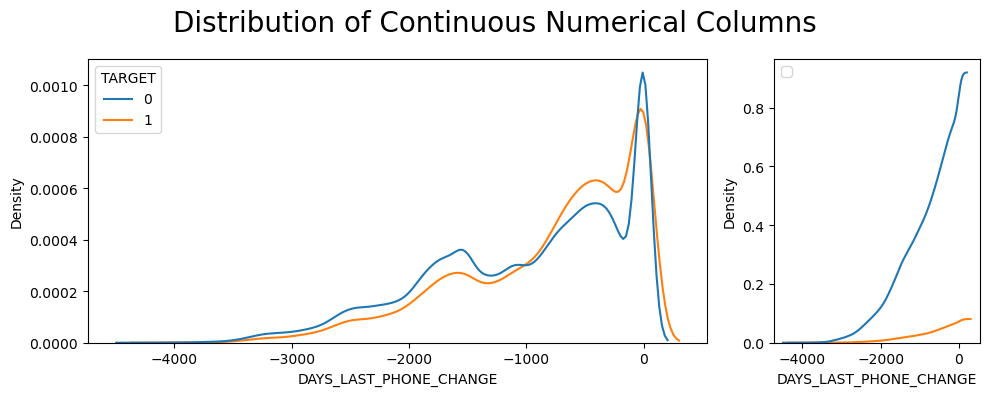

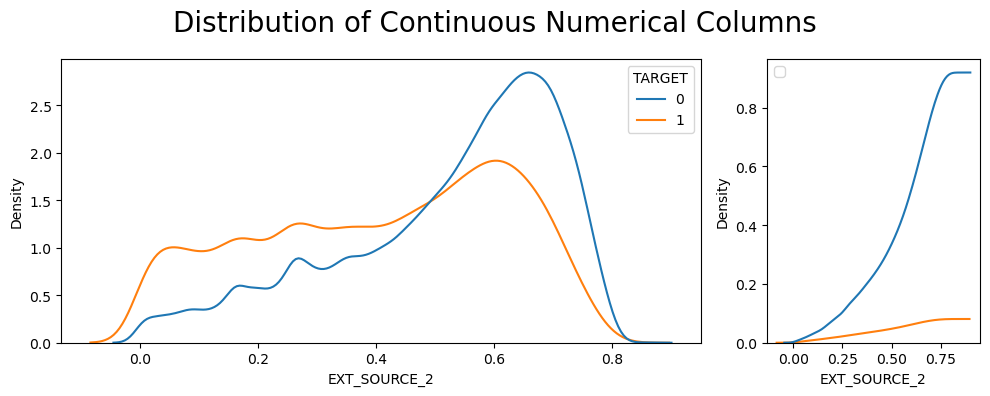

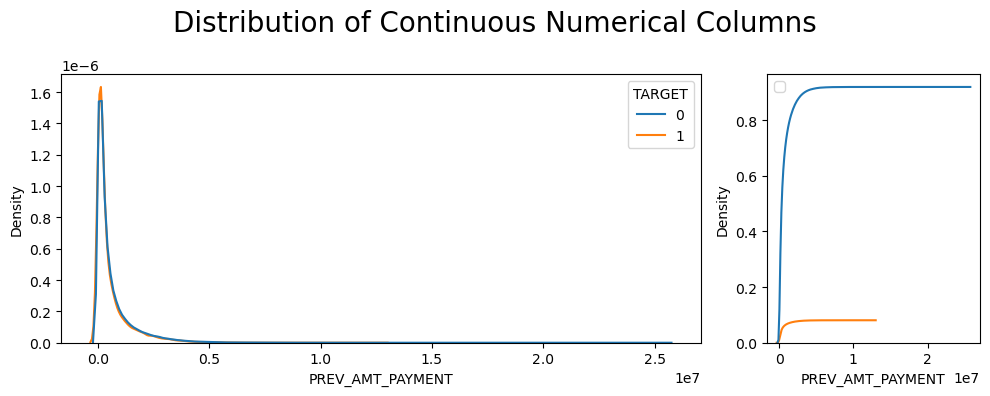

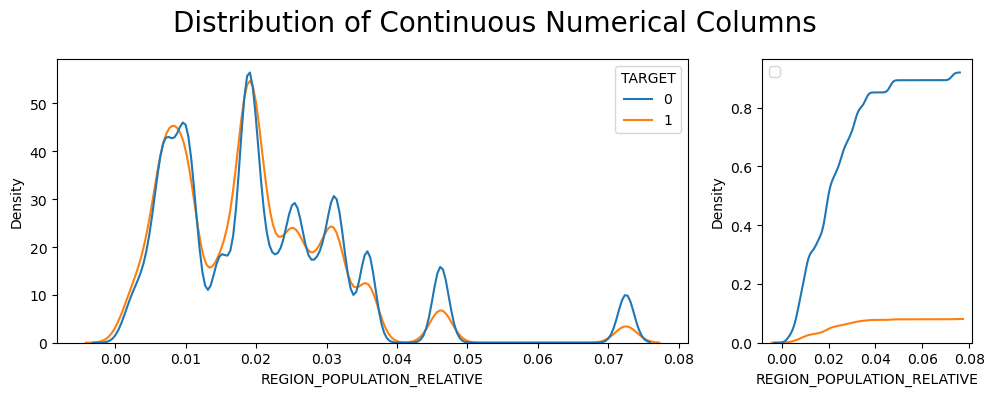

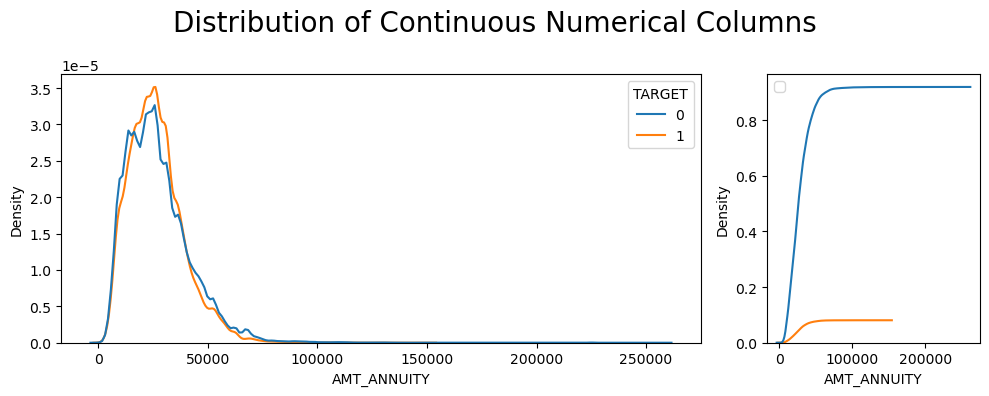

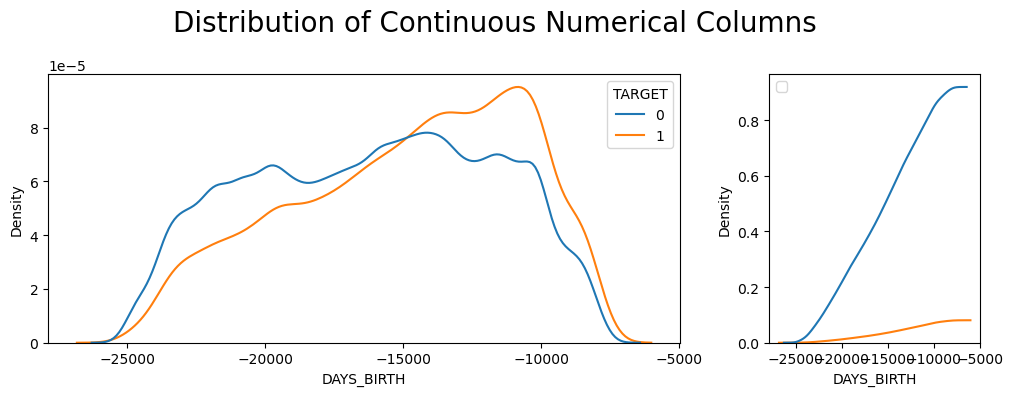

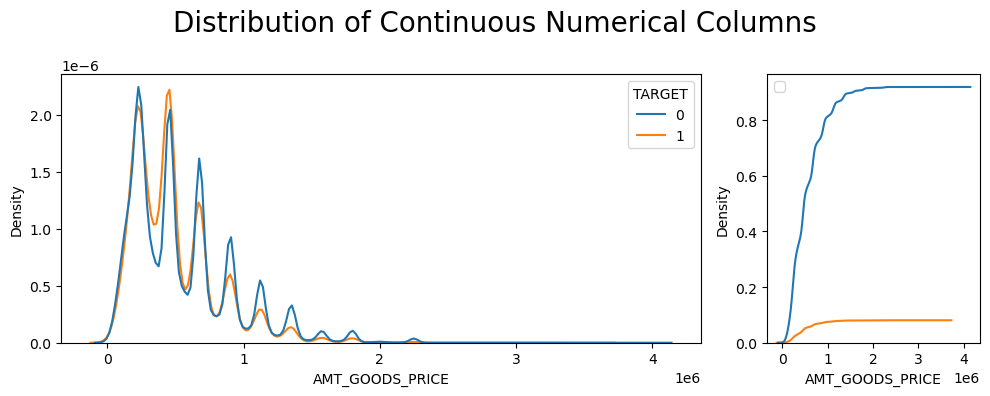

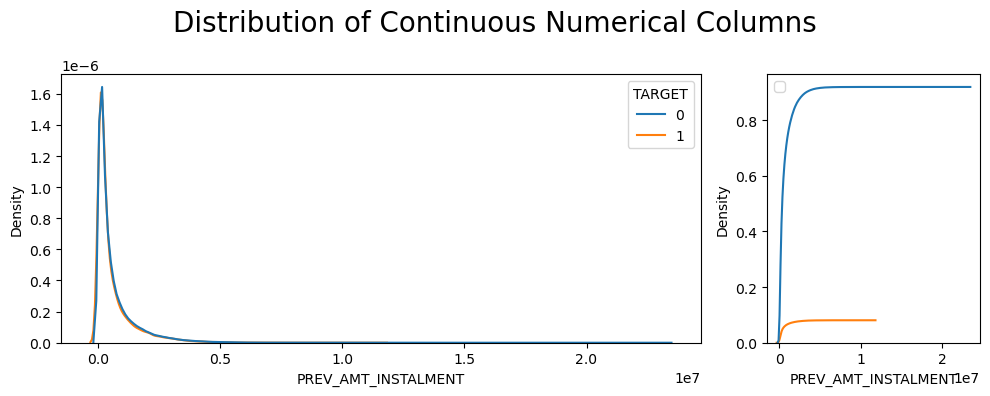

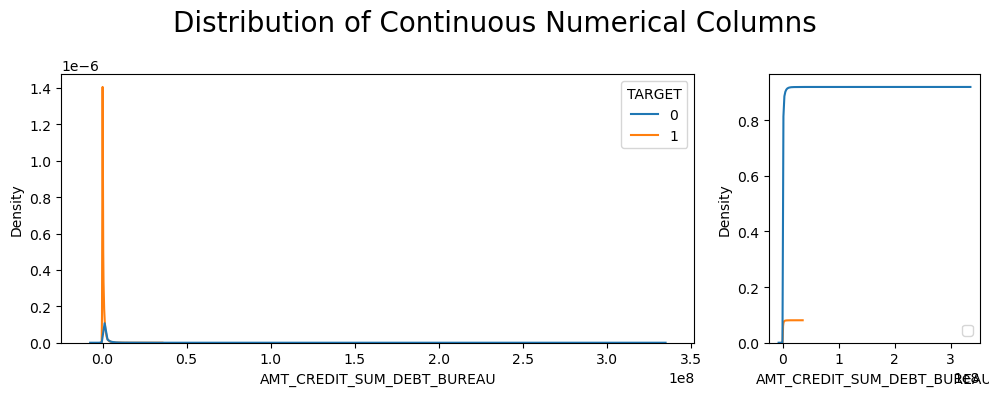

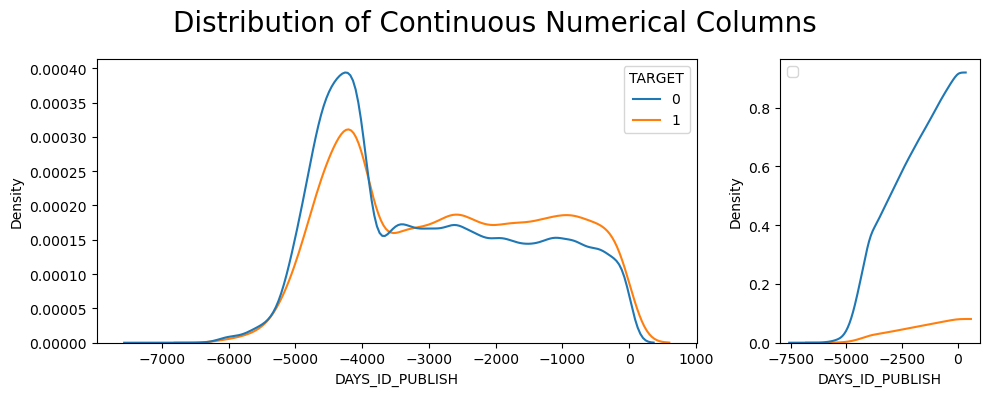

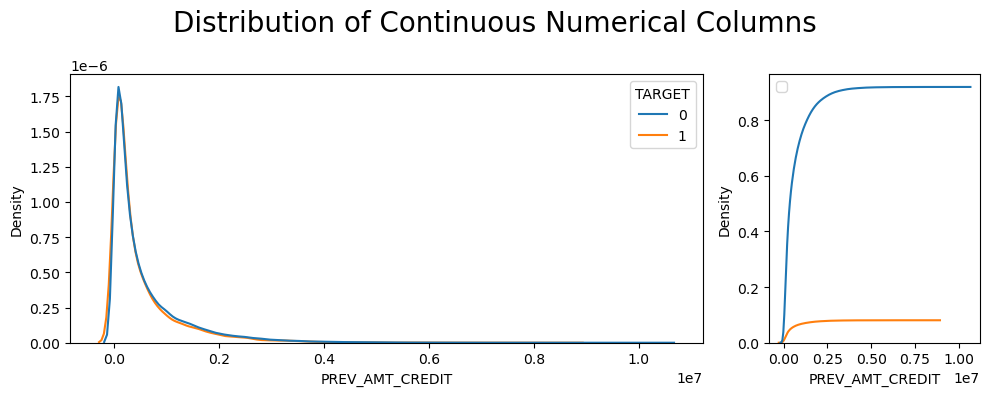

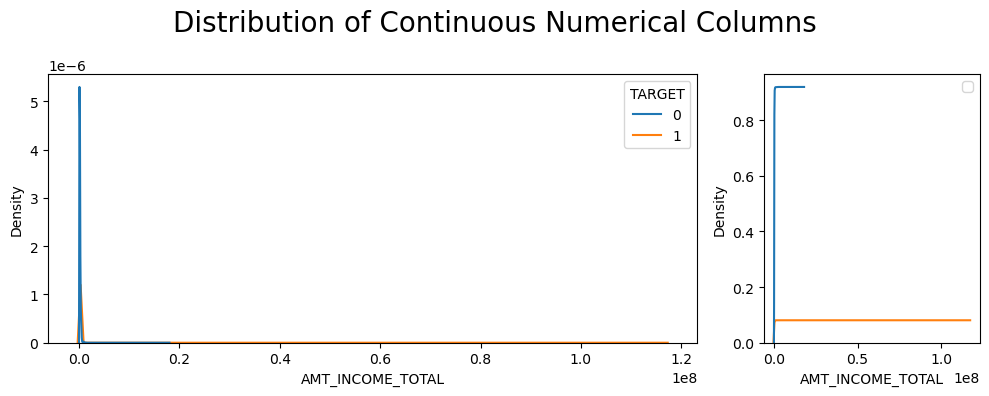

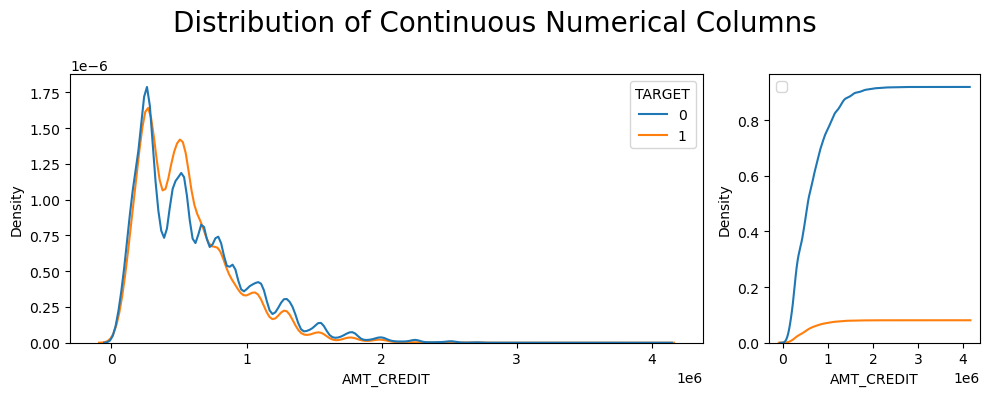

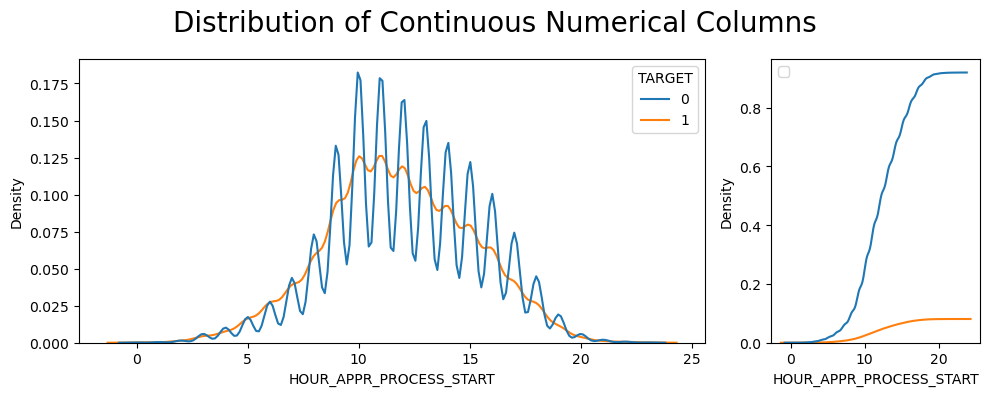

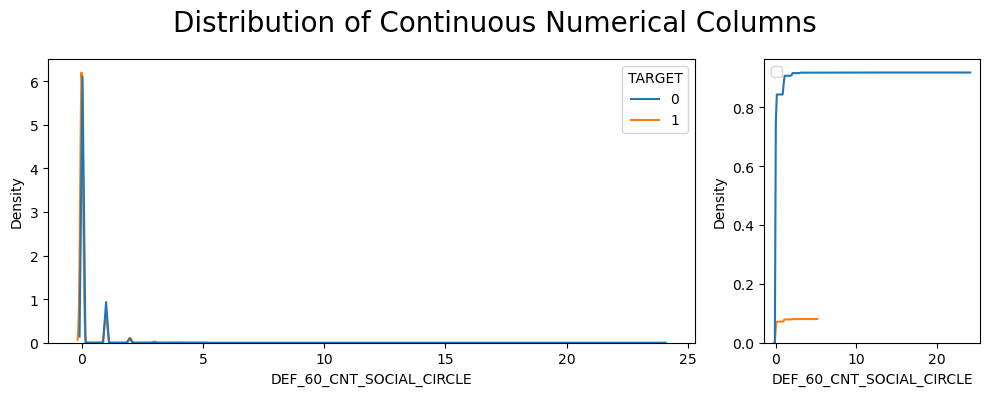

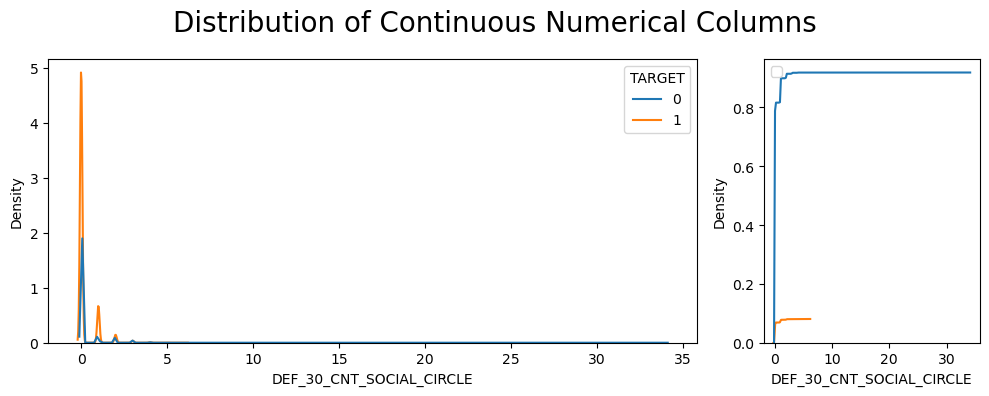

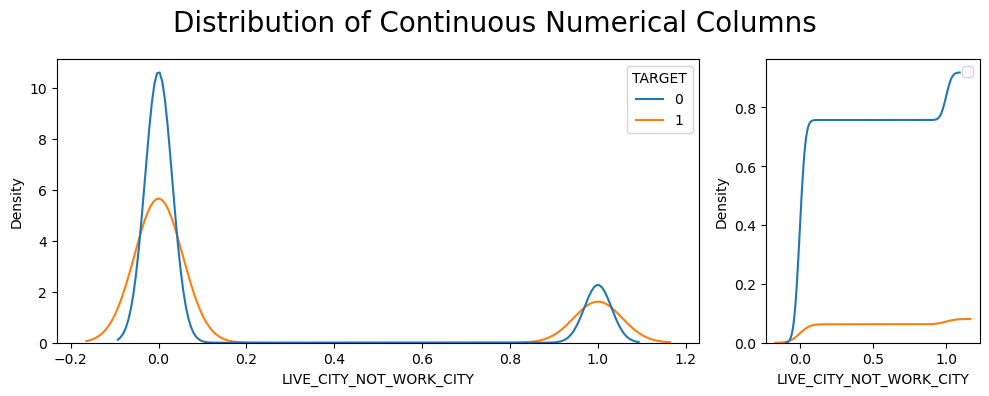

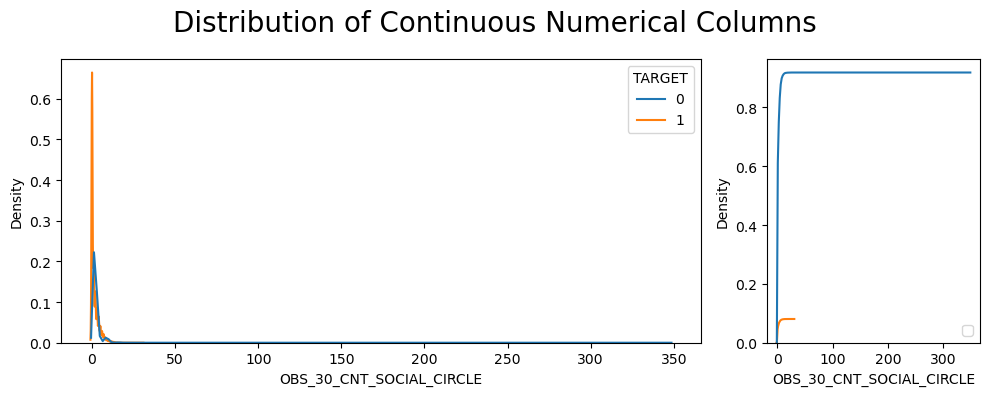

In [23]:
for col in cnum_cols:
    fig, axs = plt.subplots(1, 2, figsize=(10, 4),
                        gridspec_kw={'width_ratios': [3, 1]})
    
    sns.kdeplot(train_df, x=col, hue = 'TARGET', common_norm = False,
                ax = axs[0])
    sns.kdeplot(train_df, x=col, hue = 'TARGET', cumulative=True,
                ax = axs[1])
    axs[1].legend([])
    
    #fig.legend(loc = 'center left', bbox_to_anchor=(1,.5))
    fig.suptitle("Distribution of Continuous Numerical Columns", size=20)
    fig.tight_layout()
    plt.plot();

### Descrete Numerical Features

In [24]:
#Customized Plotting Function
def create_crosstab(df, index, column, normalize=True):
    res = pd.crosstab(index=df[index],
                      columns=df[column],
                      normalize="index")
    return res

def plot_cat(df, xc, hue,
             ax_xlabel, legend_labels,
             suptitle, title,
             xsuptitle, xtitle,
             figsize=(10,6), xlabel_rotation = 0, 
             palette = "Paired", backcolor = "#eeeeee"):
    
    df_comp = create_crosstab(df, index=xc, column=hue)
    cust_palette = sns.color_palette(palette)
    
    
    fig, (x1,x2) = plt.subplots(2,1, sharex=True,
                                figsize=figsize)

    #first plot
    bar = sns.countplot(df, x=xc, hue=hue, 
                        palette = cust_palette, order = df_comp.index.values, 
                        ax=x1)
    
    for i in bar.containers:
        bar.bar_label(i,)
    
    x1.spines.right.set_visible(False)
    x1.spines.top.set_visible(False)
    x1.spines.left.set_visible(False)
    
    x1.set_ylabel("")
    x1.set_xlabel("")
    x1.get_yaxis().set_visible(False)
    x1.set_xticklabels(labels = x1.get_xticklabels(), rotation = xlabel_rotation)
    x1.legend("")

    #second plot
    df_comp.plot(kind='bar', stacked=True, 
                 color = cust_palette, ax=x2)
    for n, x in enumerate([*df_comp.index.values]):
        for (proportion, y_loc) in zip(df_comp.loc[x],
                                       df_comp.loc[x].cumsum()):

            plt.text(x=n - 0.1,
                     y=(y_loc - proportion) + (proportion / 2),
                     s=f'{np.round(proportion * 100, 1)}%', 
                     color="black")
                               
    x2.spines.right.set_visible(False)
    x2.spines.top.set_visible(False)
    x2.spines.left.set_visible(False)
                               
    x2.legend("")
    x2.set_ylabel("")
    x2.get_yaxis().set_visible(False)
    x2.set_xlabel(ax_xlabel)
    x2.set_xticklabels(labels = x2.get_xticklabels(), rotation = xlabel_rotation)

     # Menambahkan judul
    plt.suptitle(
        t = suptitle,
        x = xsuptitle,
        fontsize = 1.2*figsize[0],
        fontweight = 'bold'
    )
    x1.set_title(
        label = title,
        x = xtitle,
        fontsize = figsize[0])
    
    fig.legend(title = hue,
               loc='center left', bbox_to_anchor=(1, 0.5), 
               labels = legend_labels)
    
    fig.patch.set_facecolor(backcolor)
    x1.patch.set_facecolor(backcolor)
    x2.patch.set_facecolor(backcolor)
    
    fig.tight_layout()
    plt.show();

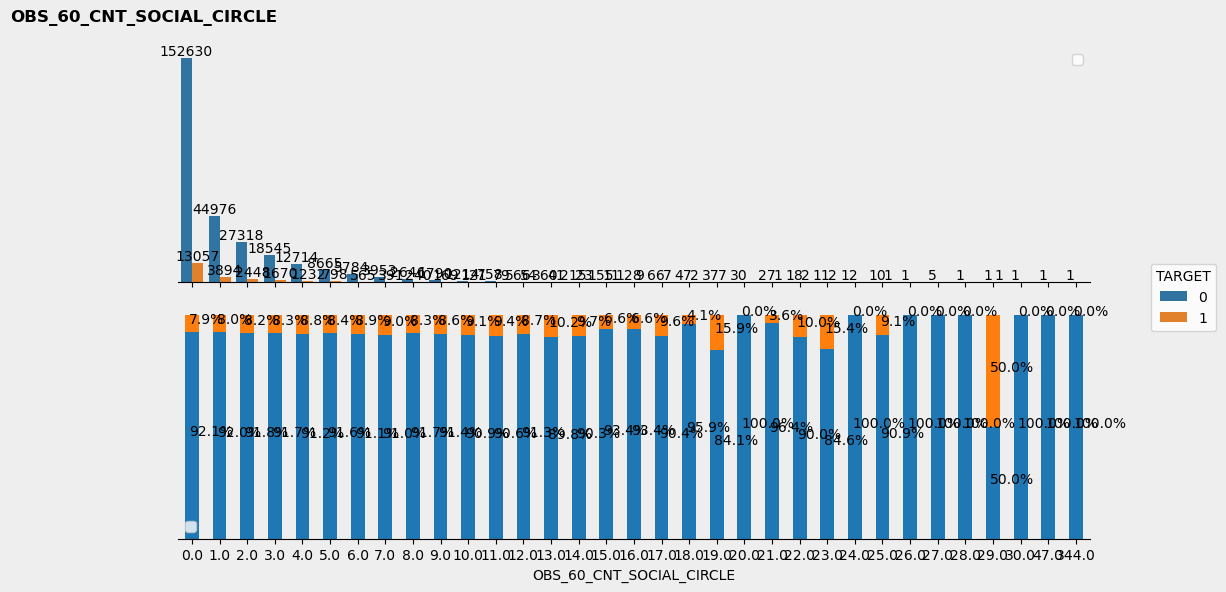

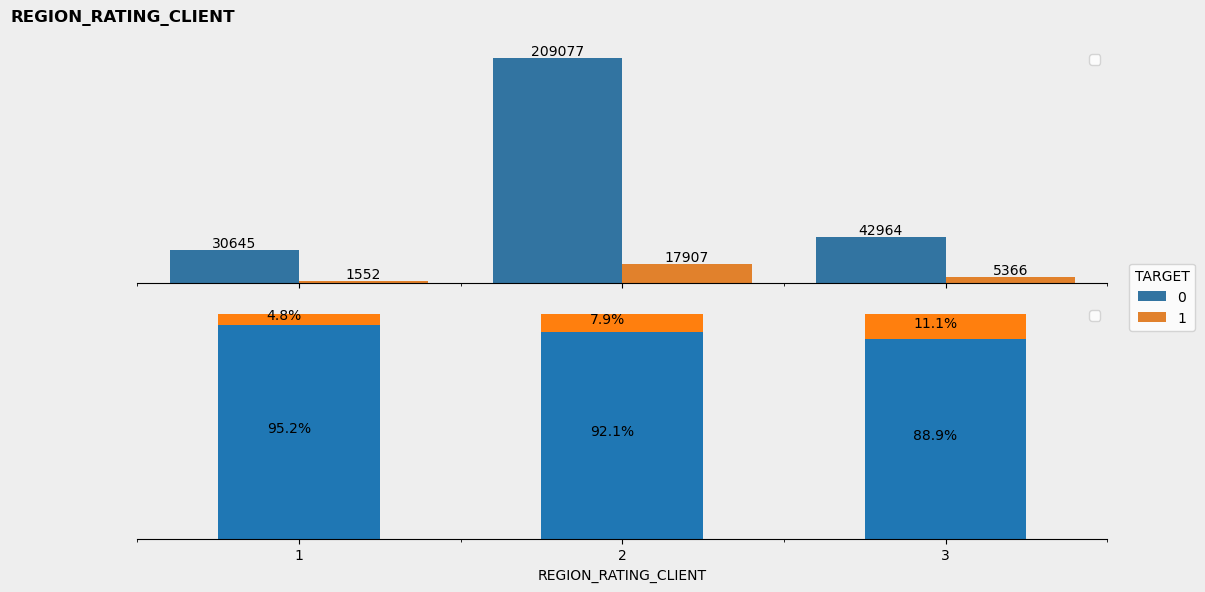

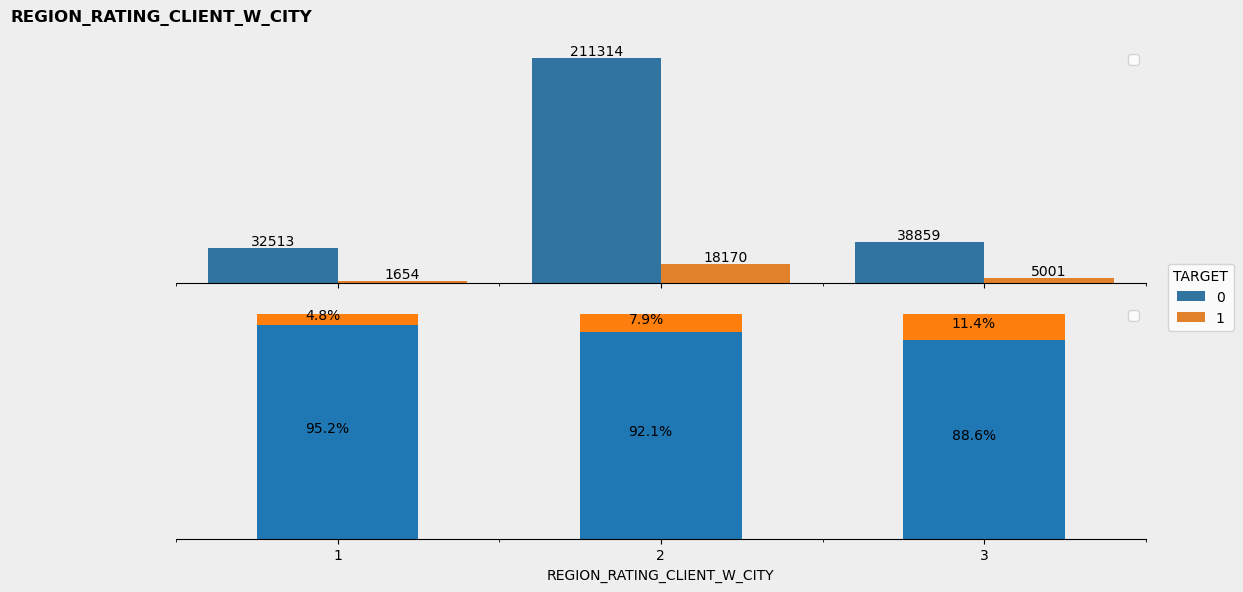

In [25]:
for i in dnum_cols:
    plot_cat(train_df, 
             xc = i, 
             hue = "TARGET",
             ax_xlabel = i, 
             legend_labels = [0, 1],
             suptitle = i,
             title = "",
             palette = None,
             xsuptitle = 0, xtitle=0)

### Categorical Features

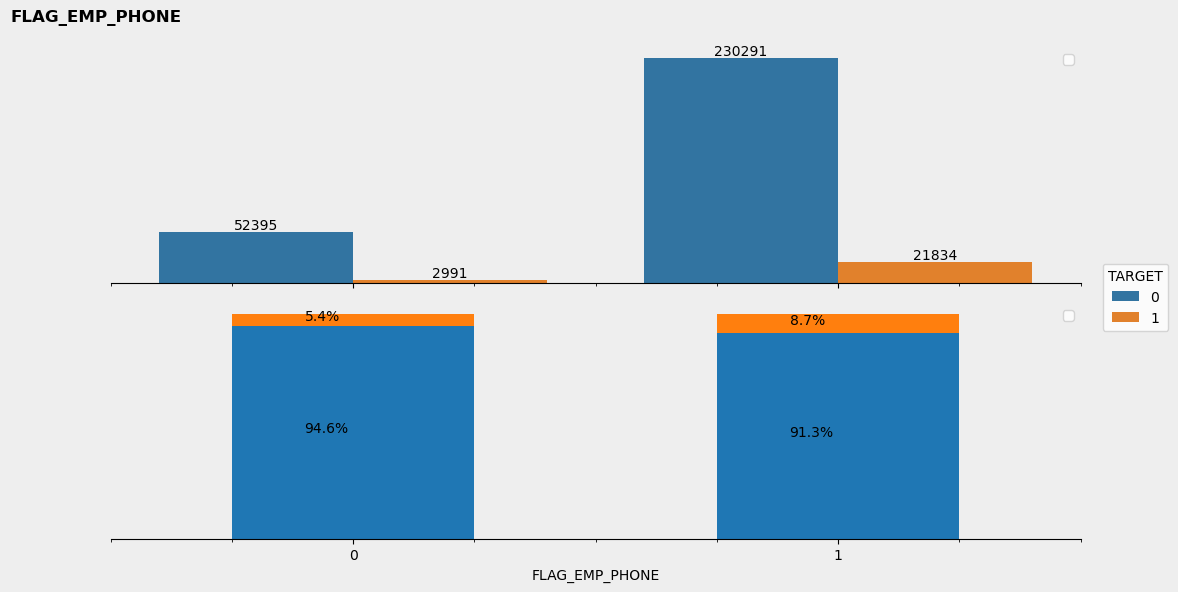

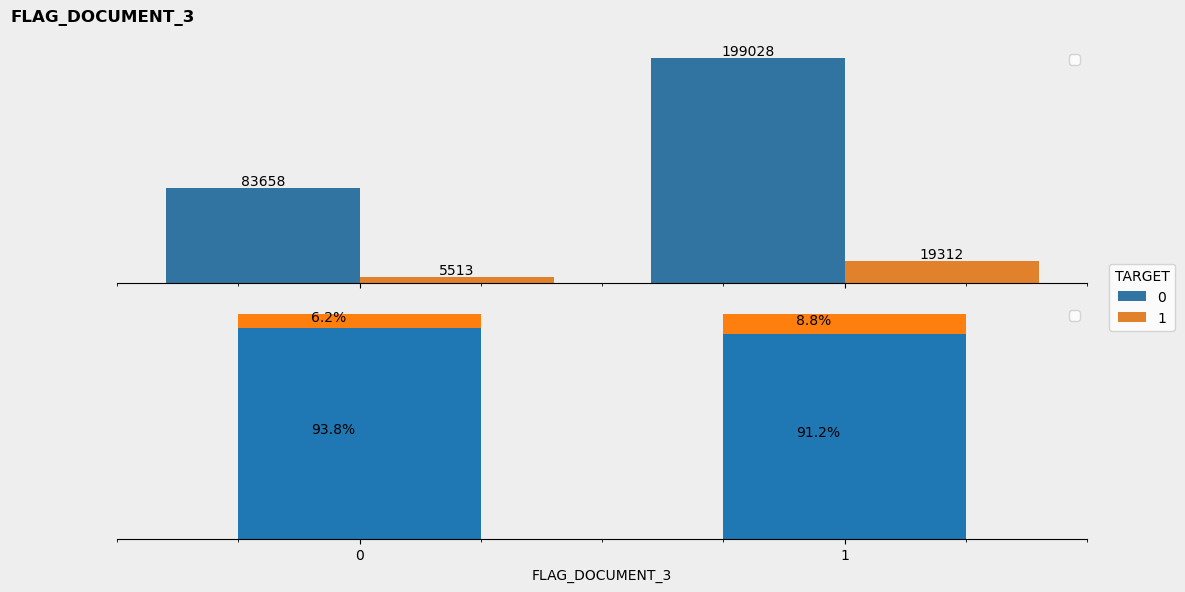

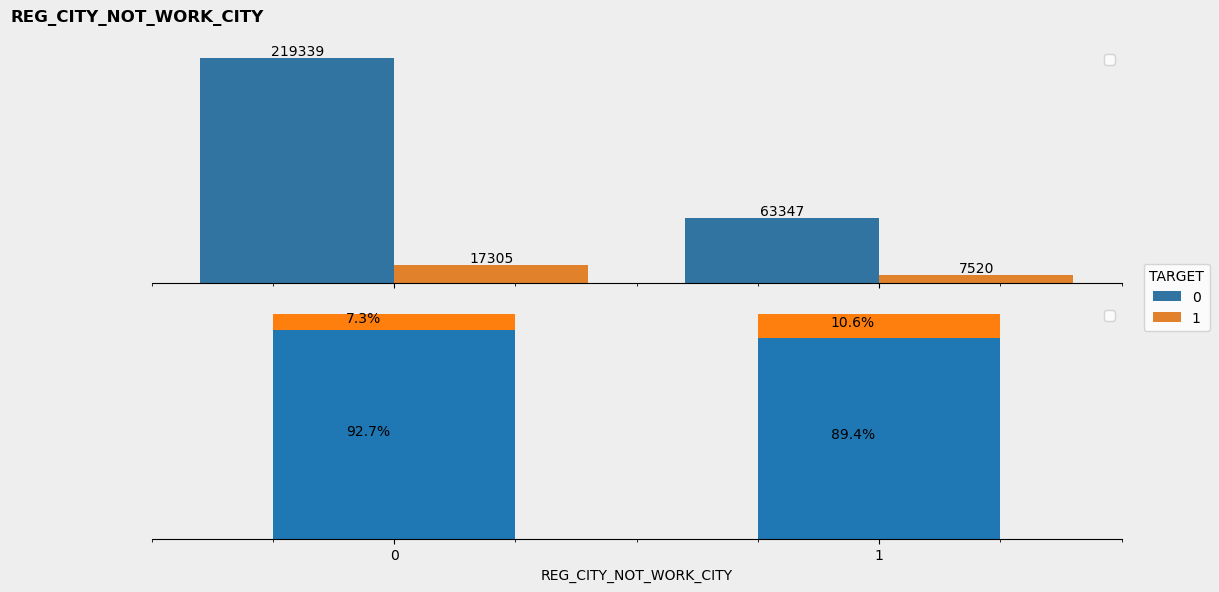

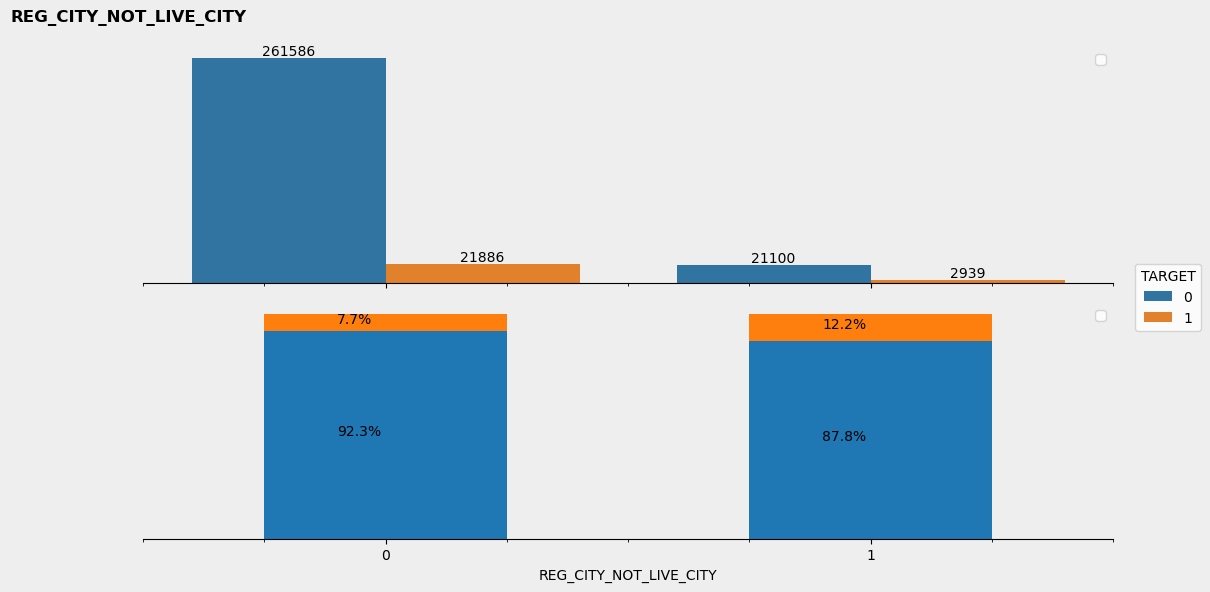

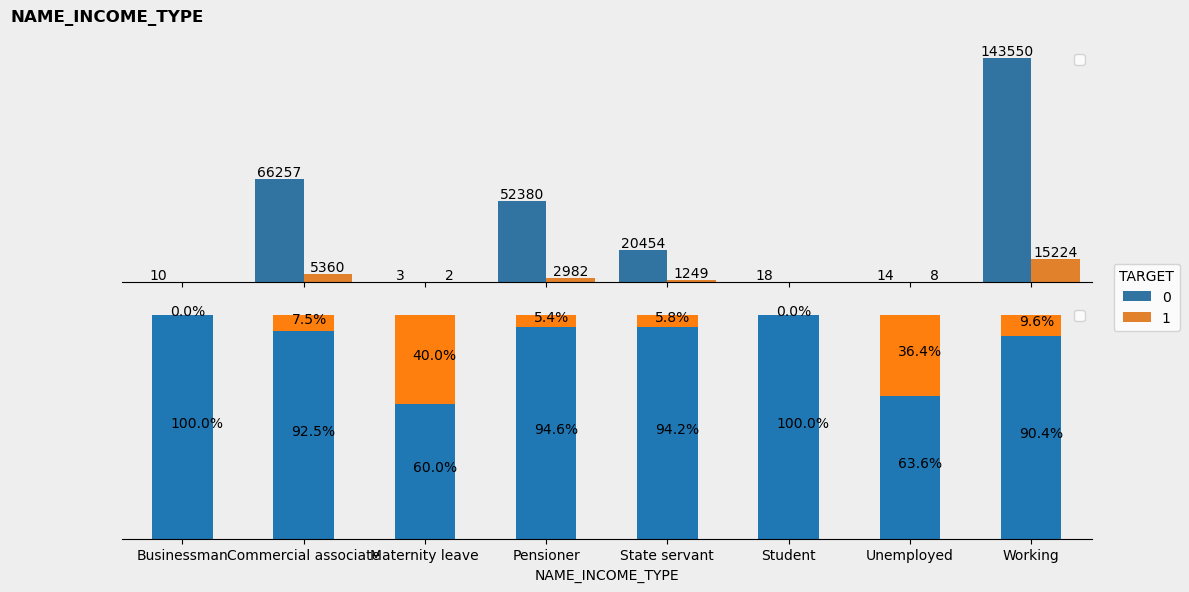

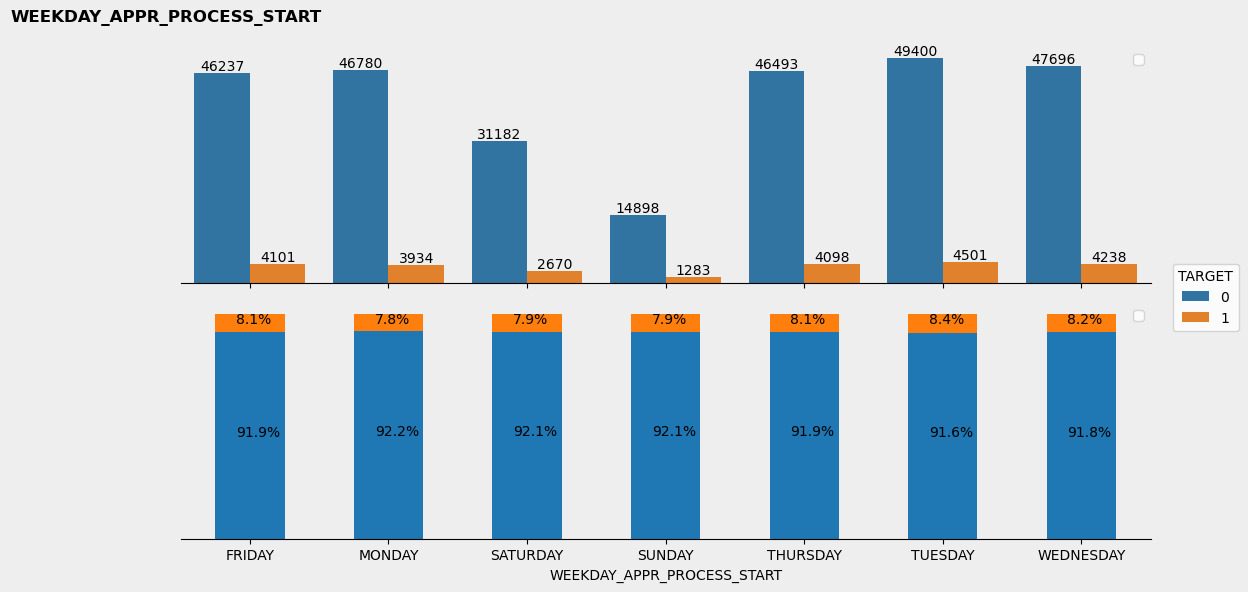

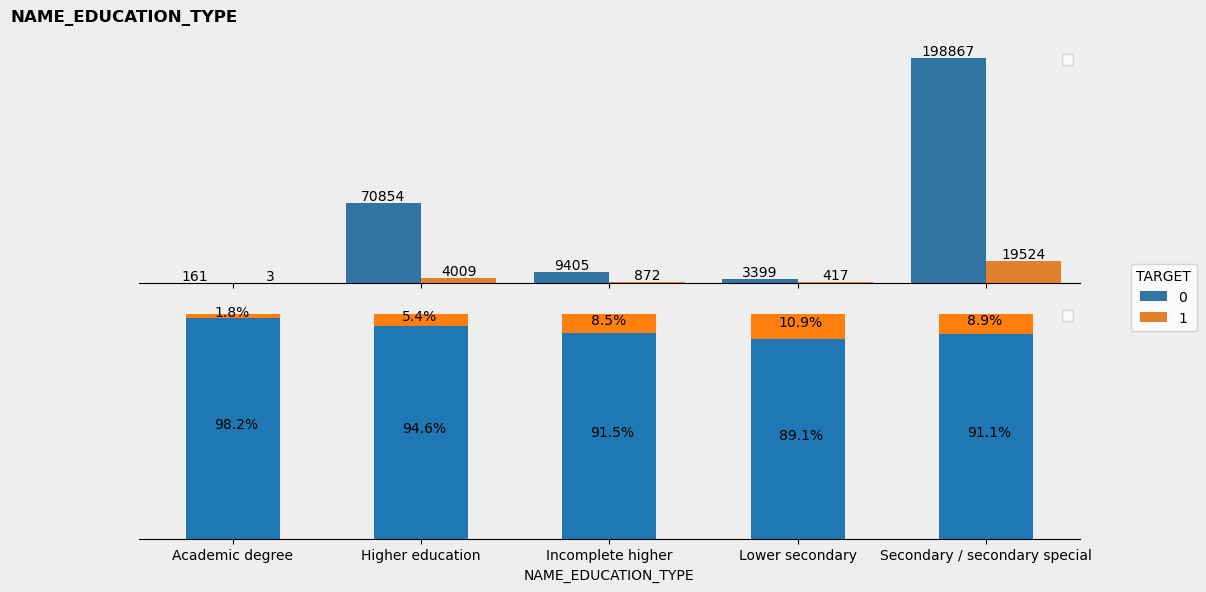

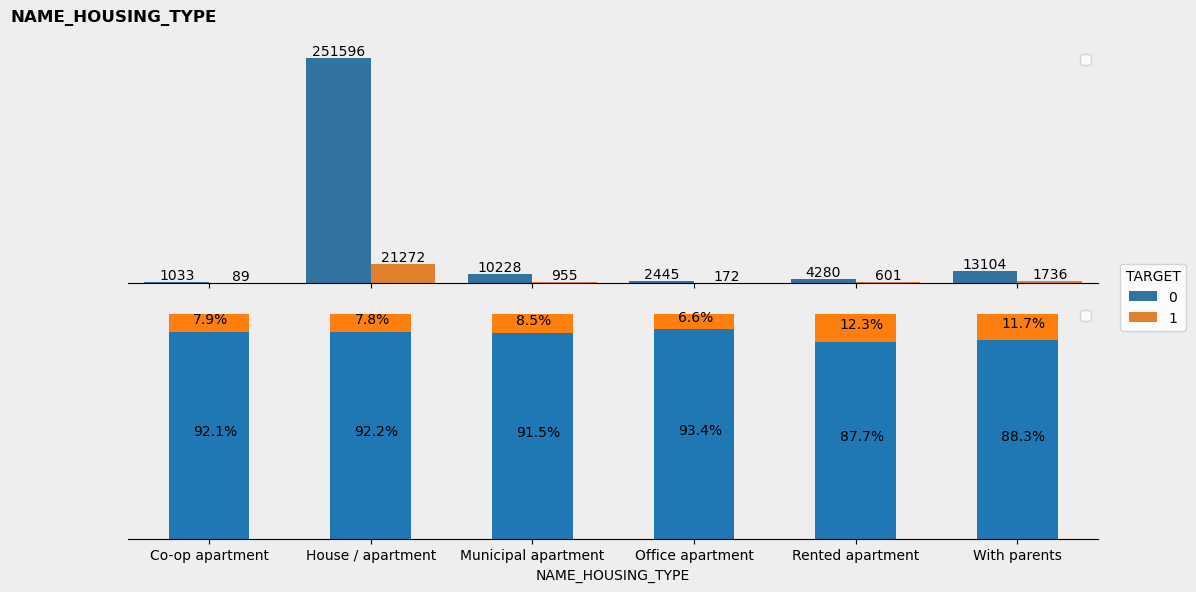

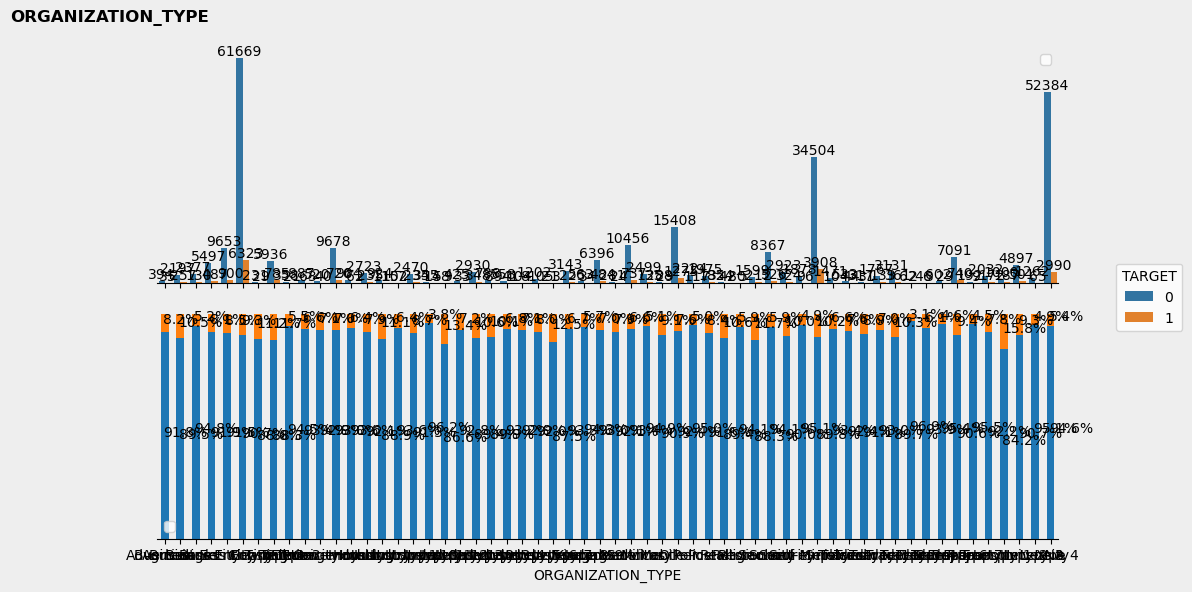

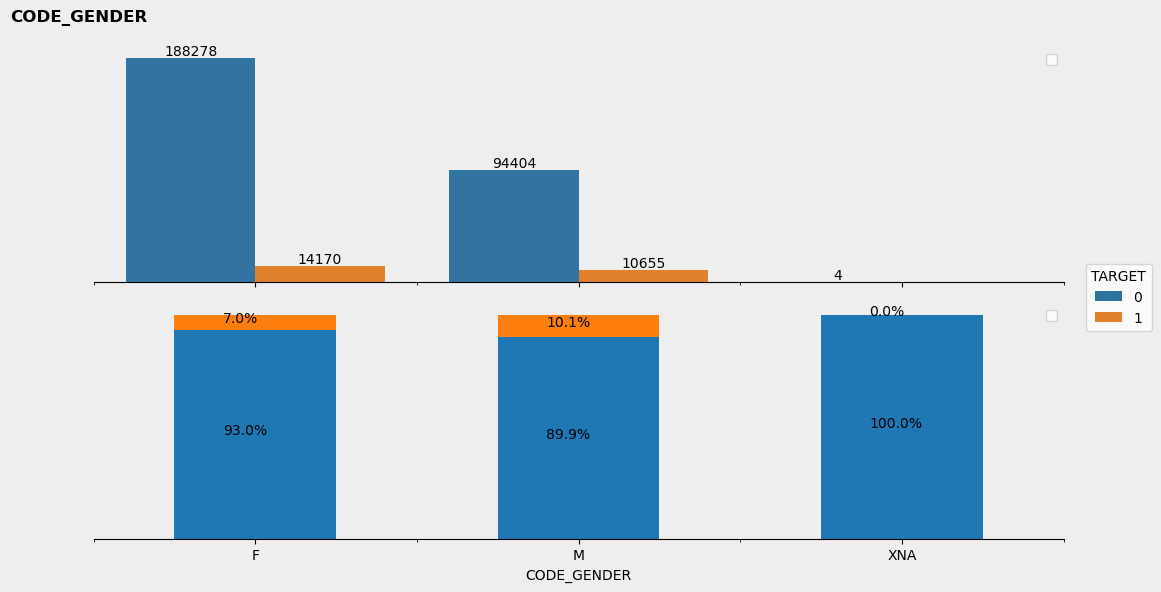

In [26]:
for i in cat_cols:
    plot_cat(train_df, 
             xc = i, 
             hue = "TARGET",
             ax_xlabel = i, 
             legend_labels = [0, 1],
             suptitle = i,
             title = "",
             palette = None,
             xsuptitle = 0, xtitle=0)

In [27]:
train_df['ORGANIZATION_TYPE'].value_counts()

ORGANIZATION_TYPE
Business Entity Type 3    67992
XNA                       55374
Self-employed             38412
Other                     16683
Medicine                  11193
Business Entity Type 2    10553
Government                10404
School                     8893
Trade: type 7              7831
Kindergarten               6880
Construction               6721
Business Entity Type 1     5984
Transport: type 4          5398
Trade: type 3              3492
Industry: type 9           3368
Industry: type 3           3278
Security                   3247
Housing                    2958
Industry: type 11          2704
Military                   2634
Bank                       2507
Agriculture                2454
Police                     2341
Transport: type 2          2204
Postal                     2157
Security Ministries        1974
Trade: type 2              1900
Restaurant                 1811
Services                   1575
University                 1327
Industry: type 7      

In [28]:
rename_val_organization = {
    'Trade: type 1':'Trade', 'Trade: type 2':'Trade', 'Trade: type 3':'Trade', 'Trade: type 4':'Trade', 'Trade: type 5':'Trade',
    'Trade: type 6':'Trade', 'Trade: type 7':'Trade',
    
    'Industry: type 1':'Industry', 'Industry: type 2':'Industry', 'Industry: type 3':'Industry', 'Industry: type 4':'Industry', 'Industry: type 5':'Industry',
    'Industry: type 6':'Industry', 'Industry: type 7':'Industry', 'Industry: type 8':'Industry', 'Industry: type 9':'Industry', 'Industry: type 10':'Industry',
    'Industry: type 11':'Industry', 'Industry: type 12':'Industry', 'Industry: type 13':'Industry', 
    
    'Transport: type 1':'Transport', 'Transport: type 2':'Transport', 'Transport: type 3':'Transport', 'Transport: type 4':'Transport',
    
    'Business Entity Type 1':'Business Entity', 'Business Entity Type 2':'Business Entity', 'Business Entity Type 3':'Business Entity'}

In [29]:
train_df['ORGANIZATION_TYPE'] = train_df['ORGANIZATION_TYPE'].replace(rename_val_organization)
test_df['ORGANIZATION_TYPE'] = test_df['ORGANIZATION_TYPE'].replace(rename_val_organization)

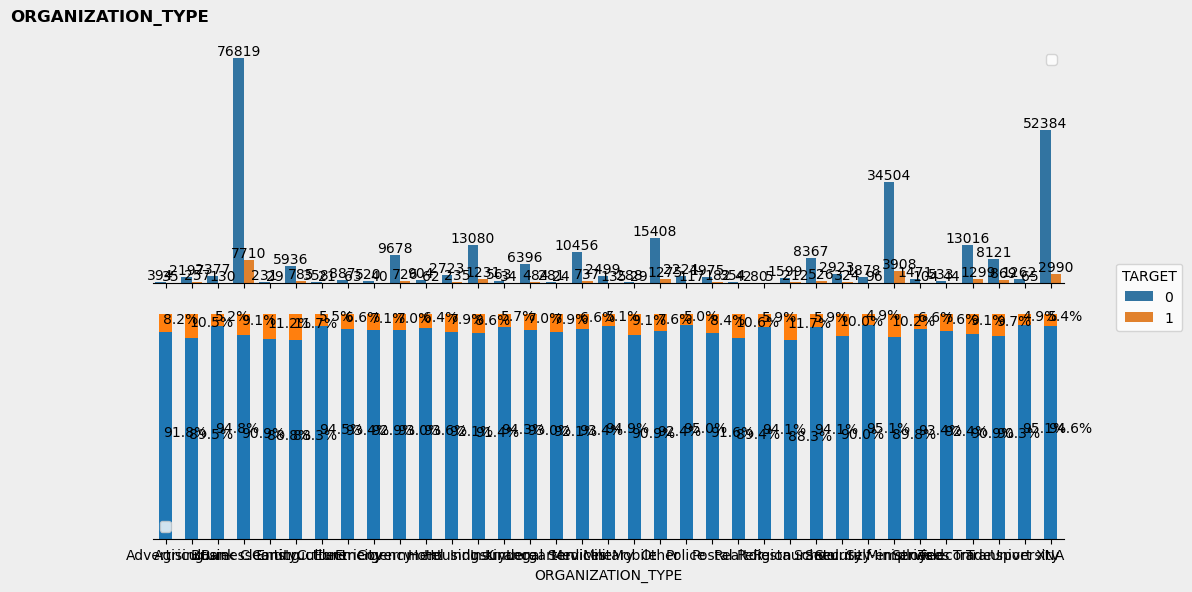

In [30]:
plot_cat(train_df, 
         xc = 'ORGANIZATION_TYPE', 
         hue = "TARGET",
         ax_xlabel = "ORGANIZATION_TYPE", 
         legend_labels = [0, 1],
         suptitle = "ORGANIZATION_TYPE",
         title = None,
         palette = None,
         xsuptitle = 0, xtitle=0)

## Bivariate Analysis

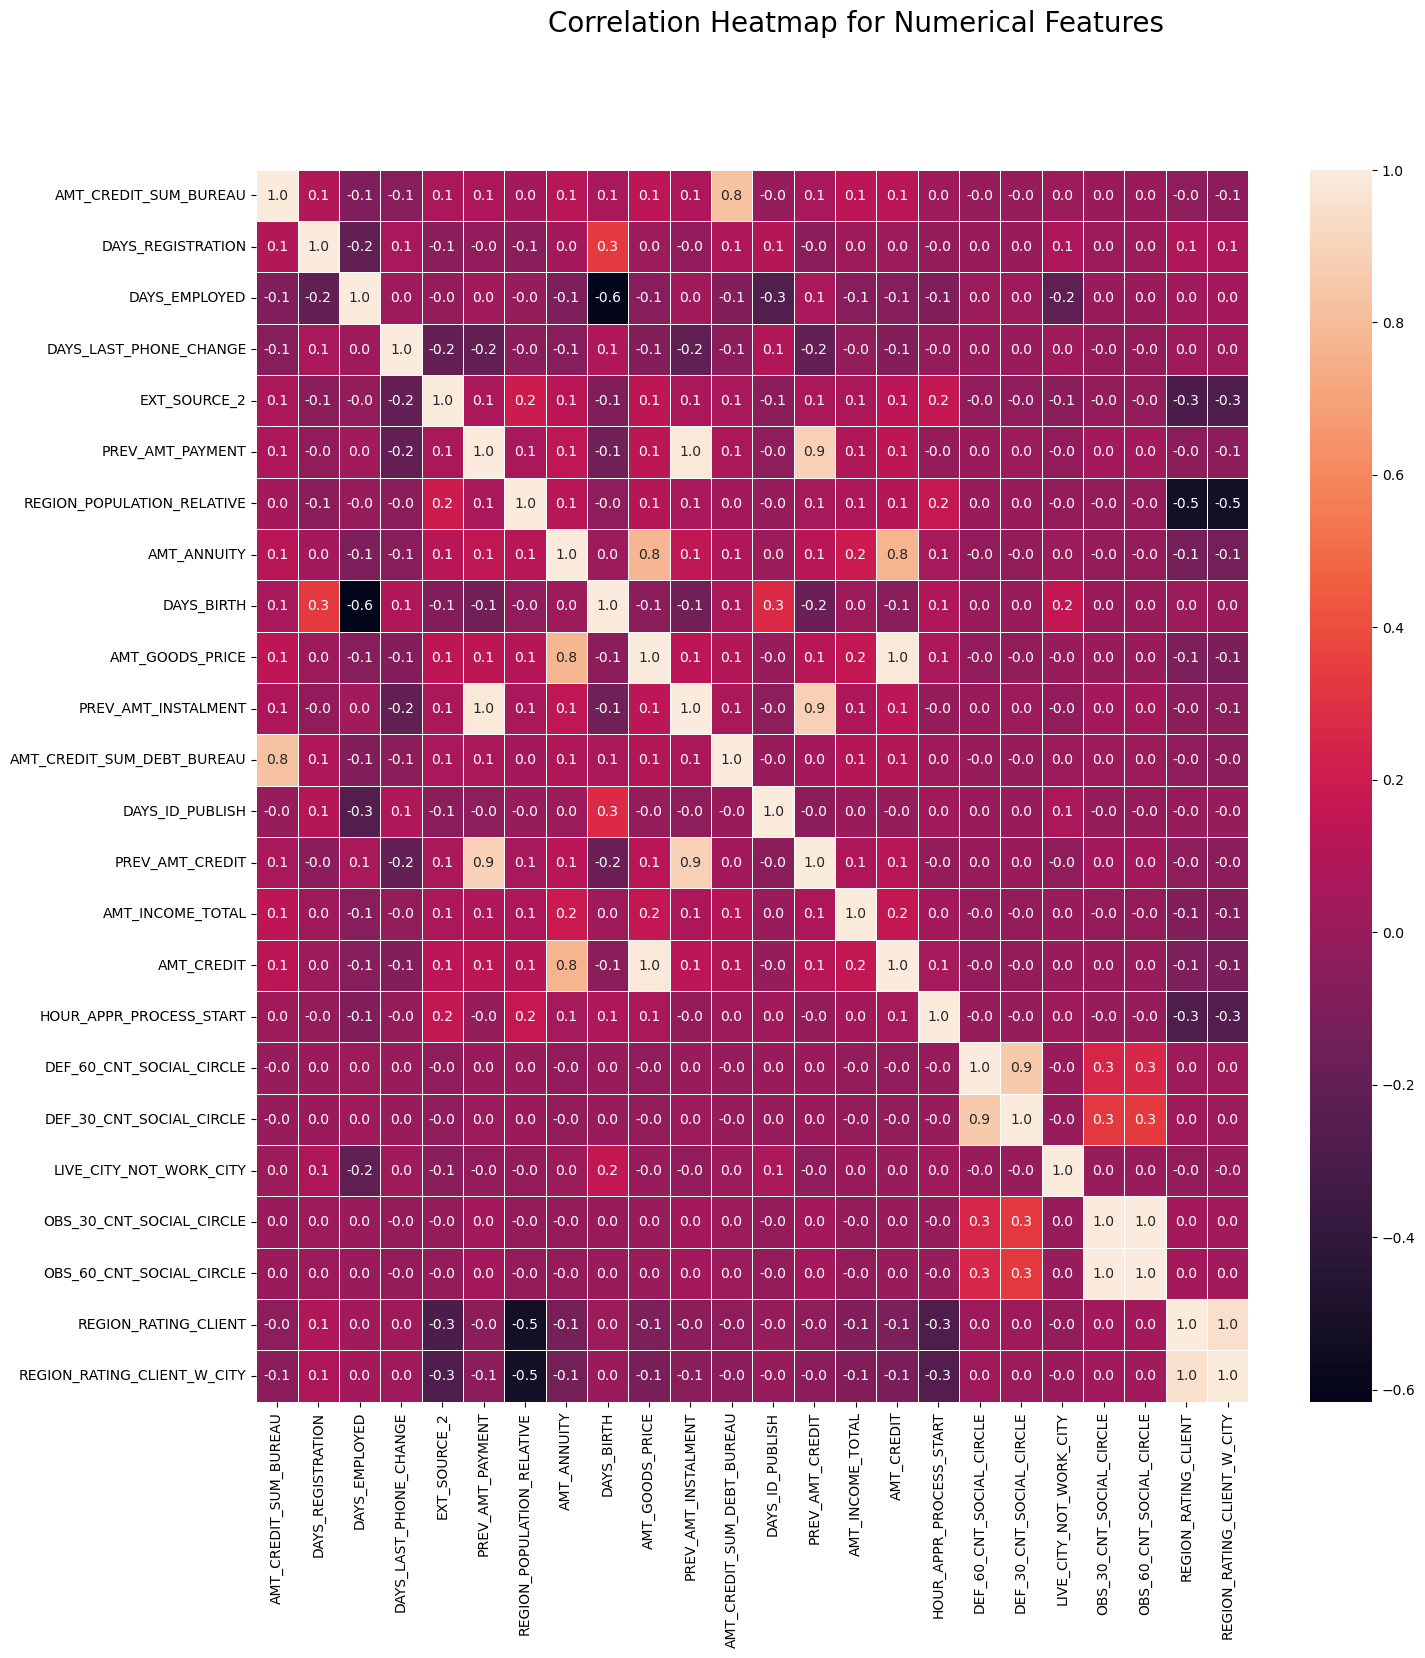

In [31]:
f, ax = plt.subplots(1,1, figsize=(16,16))

sns.heatmap(train_df[num_cols].corr(), 
            annot=True, fmt='.1f', linewidth=.5,
            ax=ax)

f.suptitle("Correlation Heatmap for Numerical Features", size=20)
f.show();

some features with high correlations in wich not interested will be removed, such as: DEF_60_CNT_SOCIAL_WORK_CITY

In [32]:
cnum_cols.remove('DEF_60_CNT_SOCIAL_CIRCLE')
num_cols = cnum_cols + dnum_cols

# Save Dataset for Model Buildings

In [33]:
selected_cols = num_cols + cat_cols
selected_cols

['AMT_CREDIT_SUM_BUREAU',
 'DAYS_REGISTRATION',
 'DAYS_EMPLOYED',
 'DAYS_LAST_PHONE_CHANGE',
 'EXT_SOURCE_2',
 'PREV_AMT_PAYMENT',
 'REGION_POPULATION_RELATIVE',
 'AMT_ANNUITY',
 'DAYS_BIRTH',
 'AMT_GOODS_PRICE',
 'PREV_AMT_INSTALMENT',
 'AMT_CREDIT_SUM_DEBT_BUREAU',
 'DAYS_ID_PUBLISH',
 'PREV_AMT_CREDIT',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'HOUR_APPR_PROCESS_START',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'LIVE_CITY_NOT_WORK_CITY',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'FLAG_EMP_PHONE',
 'FLAG_DOCUMENT_3',
 'REG_CITY_NOT_WORK_CITY',
 'REG_CITY_NOT_LIVE_CITY',
 'NAME_INCOME_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'NAME_EDUCATION_TYPE',
 'NAME_HOUSING_TYPE',
 'ORGANIZATION_TYPE',
 'CODE_GENDER']

In [34]:
train_df[selected_cols+['TARGET']].to_csv('./dataset/prepared_dataset/train.csv')
test_df[selected_cols].to_csv('./dataset/prepared_dataset/test.csv')

# Insight

1. Applicant that has lower EXIT_SOURCE_2, will likely failed to pay the credits
2. The younger applicant, the more likely applicant will failed (appx 27-40 years)
3. Applicant that has low CNT_SOCIAL_CYCLE tend to failed on pay credits
4. Amount credit appoximately between 500.000 to 800.000 is tend to failed on pay credits
5. Applicant that come from Hight region ratings could has difficulty on pay credits